In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'model9'

In [ ]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()

batch_size = 32
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

### VGG-style CNN (custom)

In [25]:
class VGG(kt.HyperModel):
    def conv_layer(self, input, filters, stride=1, kernel=3, l2_reg=0.0001, padding='same'):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding=padding, activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_uniform')(input)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None:
            dense_l2_reg = hyperparameters.Float('dense_l2_reg', 0.0001, 0.01, sampling='log')
            dense_dropout = hyperparameters.Float('dense_dropout', 0.2, 0.6, step=0.2)
        else:
            dense_l2_reg = 0.001
            dense_dropout = 0.5

        # Fixed hyperparameters
        learning_rate = 0.0005

        input_layer = layers.Input(shape=(96, 96, 1))

        output = self.conv_layer(input_layer, 32, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 32)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 64, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 64)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 256, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 256)
        output = layers.BatchNormalization()(output)
        output = layers.SpatialDropout2D(dense_dropout / 16)(output)
        output = self.conv_layer(output, 512, stride=2)
        output = layers.BatchNormalization()(output)
        output = layers.SpatialDropout2D(dense_dropout / 8)(output)
        output = self.conv_layer(output, 512)
        output = layers.BatchNormalization()(output)
        output = layers.SpatialDropout2D(dense_dropout / 4)(output)
        output = self.conv_layer(output, 1024, padding='valid')
        output = layers.BatchNormalization()(output)

        # Final output
        output = layers.Flatten()(output)
        output = layers.Dropout(dense_dropout / 2)(output)
        output = layers.Dense(
            256, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)
        output = layers.Dropout(dense_dropout)(output) 
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

VGG().build(None).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_23 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 64)        1849

In [ ]:
# Hyperparameter tuning
# Use RandomSearch to check Choice params, or Bayesian for Float/Ints

reload_tuner = False
tuner_filepath = 'hypertuner_2021-11-30'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25), # Reduce to 20 in future
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.1, patience=18, # Reduce to 15
        min_lr=0.00005, verbose=1)
]

tuner = kt.RandomSearch(VGG(),
    objective='val_accuracy',
    max_trials=5,
    seed=1,
    directory=f'models/{model_number}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=200, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# model = tuner.get_best_models(2)[1]

In [26]:
# Fit model
print('Building new model')
model, history = kaggle.train_model(
    VGG().build(None), train_dataset_augmented, valid_dataset, 
    epochs=220, valid_patience=25, epoch_length=epoch_length)

Building new model
Epoch 1/220
298/298 [==============================] - 88s 257ms/step - loss: 4.3605 - accuracy: 0.1473 - val_loss: 3.6247 - val_accuracy: 0.1842 - lr: 5.0000e-04
Epoch 2/220
298/298 [==============================] - 69s 230ms/step - loss: 3.6953 - accuracy: 0.1791 - val_loss: 3.4753 - val_accuracy: 0.2481 - lr: 5.0000e-04
Epoch 3/220
298/298 [==============================] - 69s 232ms/step - loss: 3.4863 - accuracy: 0.2077 - val_loss: 5.1265 - val_accuracy: 0.1165 - lr: 5.0000e-04
Epoch 4/220
298/298 [==============================] - 68s 229ms/step - loss: 3.3308 - accuracy: 0.2313 - val_loss: 4.0873 - val_accuracy: 0.2006 - lr: 5.0000e-04
Epoch 5/220
298/298 [==============================] - 68s 227ms/step - loss: 3.2257 - accuracy: 0.2521 - val_loss: 4.8851 - val_accuracy: 0.1745 - lr: 5.0000e-04
Epoch 6/220
298/298 [==============================] - 67s 226ms/step - loss: 3.1260 - accuracy: 0.2802 - val_loss: 7.1754 - val_accuracy: 0.1644 - lr: 5.0000e-04
Epo

INFO:tensorflow:Assets written to: models/model9/DeeperVGG2_3\assets


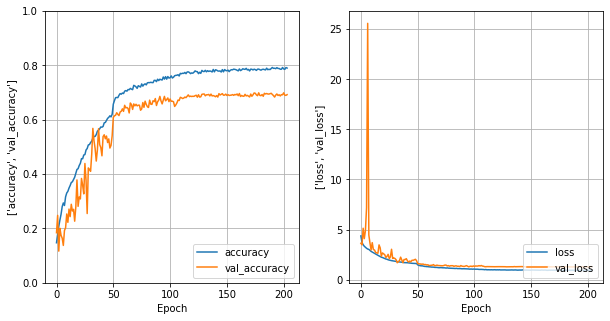

In [27]:
# Save model
model_name = 'DeeperVGG2_3'
model.save(f'models/{model_number}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [28]:
# Fine-tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model_filepath(
    f'models/{model_number}/{model_name}',
    train_dataset.batch(32), valid_dataset, 
    epochs=5, learning_rate=0.00001)

Fine-tuning model
Epoch 1/5
298/298 [==============================] - 62s 195ms/step - loss: 0.6813 - accuracy: 0.8730 - val_loss: 0.8931 - val_accuracy: 0.7973
Epoch 2/5
298/298 [==============================] - 58s 194ms/step - loss: 0.6291 - accuracy: 0.8900 - val_loss: 0.8916 - val_accuracy: 0.8007
Epoch 3/5
298/298 [==============================] - 58s 194ms/step - loss: 0.5892 - accuracy: 0.9022 - val_loss: 0.8985 - val_accuracy: 0.8019
Epoch 4/5
298/298 [==============================] - 58s 193ms/step - loss: 0.5566 - accuracy: 0.9136 - val_loss: 0.9065 - val_accuracy: 0.8024
Epoch 5/5
298/298 [==============================] - 58s 194ms/step - loss: 0.5253 - accuracy: 0.9243 - val_loss: 0.9171 - val_accuracy: 0.8057


In [29]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/DeeperVGG2_4')

INFO:tensorflow:Assets written to: models/model9/DeeperVGG2_4\assets


### Evaluate model

Accuracy: 0.8402


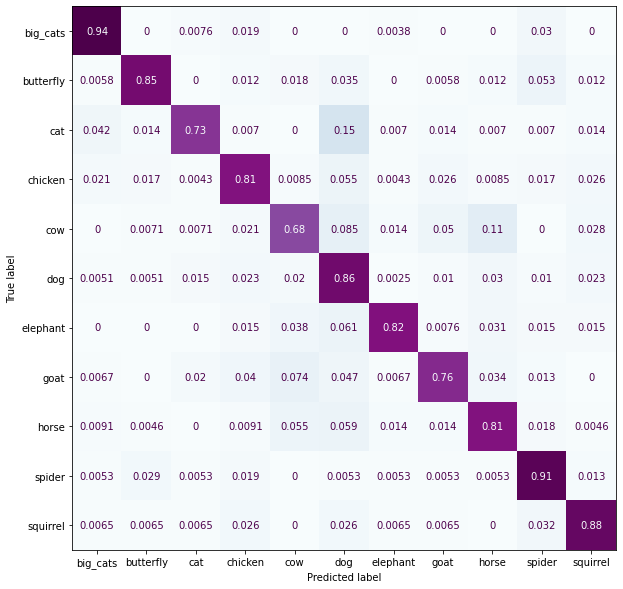

In [7]:
model_name = 'DeeperVGG2_2_84'
model = keras.models.load_model(f'models/{model_number}/{model_name}')

test_pred = np.argmax(model.predict(valid_dataset.batch(128)), axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)